## Tutorial 5 - Electric Aircraft Simulation
Welcome to this tutorial on simulating an electric aircraft using RCAIDE. This guide will walk you through the code, explain its components, and highlight where modifications can be made to customize the simulation for different vehicle designs.

---

## Header and Imports


The **Imports** section is divided into two parts: simulation-specific libraries and general-purpose Python libraries.

The **RCAIDE Imports** section includes the core modules needed for the simulation. These libraries provide specialized classes and tools for building, analyzing, and running aircraft models.


In [28]:

# ----------------------------------------------------------------------------------------------------------------------
#  IMPORT
# ----------------------------------------------------------------------------------------------------------------------
# RCAIDE imports 
import RCAIDE
from RCAIDE.Framework.Core import Units   
from RCAIDE.Library.Methods.Propulsors.Converters.Rotor             import design_propeller 
from RCAIDE.Library.Methods.Propulsors.Converters.Motor             import design_DC_motor 
from RCAIDE.Library.Methods.Weights.Correlation_Buildups.Propulsion import compute_motor_weight
from RCAIDE.Library.Methods.Geometry.Planform                       import wing_segmented_planform 
from RCAIDE.Library.Plots                                           import *     

# python imports 
import numpy as np 
from copy import deepcopy
import os 
import matplotlib.pyplot        as plt
import  pickle
import sys
sys.path.insert(0,(os.path.dirname(os.getcwd())))



## Vehicle Setup

The **`vehicle_setup`** function defines the baseline configuration of the aircraft. This section builds the vehicle step-by-step by specifying its components, geometric properties, and high-level parameters.

---

### 1. Creating the Vehicle Instance

The setup begins by creating a vehicle instance and assigning it a **tag**. The tag is a unique string identifier used to reference the vehicle during analysis or in post-processing steps.

---

### 2. Defining High-Level Vehicle Parameters

The high-level parameters describe the aircraft’s key operational characteristics, such as:

- **Maximum Takeoff Weight**: The heaviest allowable weight of the aircraft for safe flight.
- **Operating Empty Weight**: The aircraft weight without fuel, passengers, or payload.
- **Payload**: The weight of cargo and passengers.
- **Max Zero Fuel Weight**: The maximum weight of the aircraft excluding fuel.

Units for these parameters can be converted automatically using the `Units` module to ensure consistency and reduce errors.

---

### 3. Defining the Landing Gear

Landing gear parameters, such as the number of main and nose wheels, are set for the aircraft. While not used in this tutorial, these values can be applied in advanced analyses, such as **ground loads** or **noise prediction**.

---

### 4. Main Wing Setup

The main wing is added using the **`Main_Wing`** class. This designation ensures that the primary lifting surface is recognized correctly by the analysis tools. Key properties of the wing include:

- **Area**: The total wing surface area.
- **Span**: The length of the wing from tip to tip.
- **Aspect Ratio**: A ratio of span to average chord, determining wing efficiency.
- **Segments**: Divisions of the wing geometry (e.g., root and tip sections).
- **Control Surfaces**: High-lift devices like flaps and ailerons, defined by span fractions and deflections.

---

### 5. Horizontal and Vertical Stabilizers

The stabilizers provide stability and control for the aircraft:

- **Horizontal Stabilizer**: Defined using the `Horizontal_Tail` class. It follows a similar setup to the main wing but acts as a stabilizing surface.
- **Vertical Stabilizer**: Defined using the `Vertical_Tail` class, with an additional option to designate the tail as a **T-tail** for weight calculations.

---

### 6. Fuselage Definition

The fuselage is modeled by specifying its geometric parameters, such as:

- **Length**: The overall length of the aircraft body.
- **Width**: The widest part of the fuselage cross-section.
- **Height**: The height of the fuselage.

These values influence drag calculations and overall structural weight.

---

### 7. Energy Network

The **energy network** models the propulsion system. The energy network determines the engine’s thrust, bypass ratio, and fuel type. These parameters are essential for performance and fuel efficiency analyses.


---

In [29]:

# ----------------------------------------------------------------------------------------------------------------------
#   Build the Vehicle
# ----------------------------------------------------------------------------------------------------------------------
def vehicle_setup():
    
    #------------------------------------------------------------------------------------------------------------------------------------
    # ################################################# Vehicle-level Properties ########################################################  
    #------------------------------------------------------------------------------------------------------------------------------------

    vehicle                                           = RCAIDE.Vehicle()
    vehicle.tag                                       = 'X57_Maxwell_Mod2' 
    vehicle.mass_properties.max_takeoff               = 2712. * Units.pounds
    vehicle.mass_properties.takeoff                   = 2712. * Units.pounds
    vehicle.mass_properties.max_zero_fuel             = 2712. * Units.pounds 
    vehicle.mass_properties.max_payload               = 50.  * Units.pounds  # kg 
    vehicle.flight_envelope.ultimate_load             = 3.75
    vehicle.flight_envelope.positive_limit_load       = 2.5 
    vehicle.flight_envelope.design_mach_number        = 0.78 
    vehicle.flight_envelope.design_cruise_altitude    = 2500. * Units.ft
    vehicle.flight_envelope.design_range              = 200 * Units.nmi 
    vehicle.reference_area                            = 14.76
    vehicle.passengers                                = 4
    vehicle.systems.control                           = "fully powered"
    vehicle.systems.accessories                       = "commuter"    
                 
    cruise_speed                                      = 135.*Units['mph']    
    atmo                                              = RCAIDE.Framework.Analyses.Atmospheric.US_Standard_1976()
    freestream                                        = atmo.compute_values (0.)
    freestream0                                       = atmo.compute_values (vehicle.flight_envelope.design_cruise_altitude )
    mach_number                                       = (cruise_speed/freestream.speed_of_sound)[0][0] 
    vehicle.design_dynamic_pressure                   = ( .5 *freestream0.density*(cruise_speed*cruise_speed))[0][0]
    vehicle.design_mach_number                        =  mach_number

         
    #------------------------------------------------------------------------------------------------------------------------------------
    # ######################################################## Wings ####################################################################  
    #------------------------------------------------------------------------------------------------------------------------------------
    # ------------------------------------------------------------------
    #   Main Wing
    # ------------------------------------------------------------------
    
    wing                                  = RCAIDE.Library.Components.Wings.Main_Wing()
    wing.tag                              = 'main_wing' 
    wing.sweeps.quarter_chord             = 0.0 * Units.deg
    wing.thickness_to_chord               = 0.12
    wing.areas.reference                  = 14.76
    wing.spans.projected                  = 11.4 
    wing.chords.root                      = 1.46
    wing.chords.tip                       = 0.92
    wing.chords.mean_aerodynamic          = 1.19
    wing.taper                            = wing.chords.root/wing.chords.tip 
    wing.aspect_ratio                     = wing.spans.projected**2. / wing.areas.reference 
    wing.twists.root                      = 3.0 * Units.degrees
    wing.twists.tip                       = 0.0 * Units.degrees 
    wing.origin                           = [[2.93, 0., 1.01]]
    wing.aerodynamic_center               = [3., 0., 1.01] 
    wing.vertical                         = False
    wing.symmetric                        = True
    wing.high_lift                        = True 
    wing.winglet_fraction                 = 0.0  
    wing.dynamic_pressure_ratio           = 1.0  
    ospath                                = os.path.abspath(os.path.join('Notebook'))
    separator                             = os.path.sep
    rel_path = os.path.dirname(ospath) + separator + '..' + separator + '..' + separator + 'Regressions' + separator + 'Vehicles' + separator
    airfoil                               = RCAIDE.Library.Components.Airfoils.Airfoil()
    airfoil.tag                           = 'NACA_63_412.txt' 
    airfoil.coordinate_file               = rel_path + 'Airfoils' + separator + 'NACA_63_412.txt'   # absolute path     
    cg_x                                  = wing.origin[0][0] + 0.25*wing.chords.mean_aerodynamic
    cg_z                                  = wing.origin[0][2] - 0.2*wing.chords.mean_aerodynamic
    vehicle.mass_properties.center_of_gravity = [[cg_x,   0.  ,  cg_z ]]  # SOURCE: Design and aerodynamic analysis of a twin-engine commuter aircraft

    # Wing Segments
    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'inboard'
    segment.percent_span_location         = 0.0 
    segment.twist                         = 3. * Units.degrees   
    segment.root_chord_percent            = 1. 
    segment.dihedral_outboard             = 0.  
    segment.sweeps.quarter_chord          = 0.
    segment.thickness_to_chord            = 0.12
    segment.append_airfoil(airfoil)
    wing.append_segment(segment)

    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'outboard'
    segment.percent_span_location         = 0.5438
    segment.twist                         = 2.* Units.degrees 
    segment.root_chord_percent            = 1. 
    segment.dihedral_outboard             = 0. 
    segment.sweeps.quarter_chord          = 0.
    segment.thickness_to_chord            = 0.12 
    segment.append_airfoil(airfoil)
    wing.append_segment(segment)
    
    # Wing Segments
    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'winglet'
    segment.percent_span_location         = 0.98
    segment.twist                         = 1.  * Units.degrees 
    segment.root_chord_percent            = 0.630
    segment.dihedral_outboard             = 75. * Units.degrees 
    segment.sweeps.quarter_chord          = 30. * Units.degrees 
    segment.thickness_to_chord            = 0.12 
    segment.append_airfoil(airfoil)
    wing.append_segment(segment) 

    segment                               = RCAIDE.Library.Components.Wings.Segments.Segment()
    segment.tag                           = 'tip'
    segment.percent_span_location         = 1.
    segment.twist                         = 0. * Units.degrees 
    segment.root_chord_percent            = 0.12
    segment.dihedral_outboard             = 0.
    segment.sweeps.quarter_chord          = 0.
    segment.thickness_to_chord            = 0.12
    segment.append_airfoil(airfoil)
    wing.append_segment(segment)    
    
    # Fill out more segment properties automatically
    wing = wing_segmented_planform(wing)           
    
    # add to vehicle
    vehicle.append_component(wing)


    #------------------------------------------------------------------------------------------------------------------------------------  
    #   Horizontal Tail
    #------------------------------------------------------------------------------------------------------------------------------------    
    wing                                  = RCAIDE.Library.Components.Wings.Wing()
    wing.tag                              = 'horizontal_stabilizer' 
    wing.sweeps.quarter_chord             = 0.0 * Units.deg
    wing.thickness_to_chord               = 0.12
    wing.areas.reference                  = 2.540 
    wing.spans.projected                  = 3.3  * Units.meter 
    wing.sweeps.quarter_chord             = 0 * Units.deg 
    wing.chords.root                      = 0.769 * Units.meter 
    wing.chords.tip                       = 0.769 * Units.meter 
    wing.chords.mean_aerodynamic          = 0.769 * Units.meter  
    wing.taper                            = 1. 
    wing.aspect_ratio                     = wing.spans.projected**2. / wing.areas.reference 
    wing.twists.root                      = 0.0 * Units.degrees
    wing.twists.tip                       = 0.0 * Units.degrees 
    wing.origin                           = [[7.7, 0., 0.25]]
    wing.aerodynamic_center               = [7.8, 0., 0.25] 
    wing.vertical                         = False
    wing.winglet_fraction                 = 0.0  
    wing.symmetric                        = True
    wing.high_lift                        = False 
    wing.dynamic_pressure_ratio           = 0.9

    # add to vehicle
    vehicle.append_component(wing)


    #------------------------------------------------------------------------------------------------------------------------------------  
    #   Vertical Stabilizer
    #------------------------------------------------------------------------------------------------------------------------------------ 
    wing                                  = RCAIDE.Library.Components.Wings.Wing()
    wing.tag                              = 'vertical_stabilizer'     
    wing.sweeps.quarter_chord             = 25. * Units.deg
    wing.thickness_to_chord               = 0.12
    wing.areas.reference                  = 2.258 * Units['meters**2']  
    wing.spans.projected                  = 1.854   * Units.meter  
    wing.chords.root                      = 1.6764 * Units.meter 
    wing.chords.tip                       = 0.6858 * Units.meter 
    wing.chords.mean_aerodynamic          = 1.21   * Units.meter 
    wing.taper                            = wing.chords.tip/wing.chords.root 
    wing.aspect_ratio                     = wing.spans.projected**2. / wing.areas.reference 
    wing.twists.root                      = 0.0 * Units.degrees
    wing.twists.tip                       = 0.0 * Units.degrees 
    wing.origin                           = [[6.75 ,0, 0.623]]
    wing.aerodynamic_center               = [0.508 ,0,0]  
    wing.vertical                         = True 
    wing.symmetric                        = False
    wing.t_tail                           = False
    wing.winglet_fraction                 = 0.0  
    wing.dynamic_pressure_ratio           = 1.0

    # add to vehicle
    vehicle.append_component(wing)

 
    # ##########################################################   Fuselage  ############################################################    
    fuselage = RCAIDE.Library.Components.Fuselages.Tube_Fuselage() 
    fuselage.seats_abreast                      = 2.
    fuselage.fineness.nose                      = 1.6
    fuselage.fineness.tail                      = 2.
    fuselage.lengths.nose                       = 60.  * Units.inches
    fuselage.lengths.tail                       = 161. * Units.inches
    fuselage.lengths.cabin                      = 105. * Units.inches
    fuselage.lengths.total                      = 332.2* Units.inches
    fuselage.lengths.fore_space                 = 0.
    fuselage.lengths.aft_space                  = 0.
    fuselage.width                              = 42. * Units.inches
    fuselage.heights.maximum                    = 62. * Units.inches
    fuselage.heights.at_quarter_length          = 62. * Units.inches
    fuselage.heights.at_three_quarters_length   = 62. * Units.inches
    fuselage.heights.at_wing_root_quarter_chord = 23. * Units.inches
    fuselage.areas.side_projected               = 8000.  * Units.inches**2.
    fuselage.areas.wetted                       = 30000. * Units.inches**2.
    fuselage.areas.front_projected              = 42.* 62. * Units.inches**2.
    fuselage.effective_diameter                 = 50. * Units.inches 

    # Segment
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_0'
    segment.percent_x_location                  = 0
    segment.percent_z_location                  = 0
    segment.height                              = 0.01
    segment.width                               = 0.01
    fuselage.append_segment(segment)

    # Segment
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_1'
    segment.percent_x_location                  = 0.007279116466
    segment.percent_z_location                  = 0.002502014453
    segment.height                              = 0.1669064748
    segment.width                               = 0.2780205877
    fuselage.append_segment(segment)

    # Segment
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_2'
    segment.percent_x_location                  = 0.01941097724
    segment.percent_z_location                  = 0.001216095397
    segment.height                              = 0.3129496403
    segment.width                               = 0.4365777215
    fuselage.append_segment(segment)

    # Segment
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_3'
    segment.percent_x_location                  = 0.06308567604
    segment.percent_z_location                  = 0.007395489231
    segment.height                              = 0.5841726619
    segment.width                               = 0.6735119903
    fuselage.append_segment(segment)

    # Segment
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_4'
    segment.percent_x_location                  = 0.1653761217
    segment.percent_z_location                  = 0.02891281352
    segment.height                              = 1.064028777
    segment.width                               = 1.067200529
    fuselage.append_segment(segment)

    # Segment
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_5'
    segment.percent_x_location                  = 0.2426372155
    segment.percent_z_location                  = 0.04214148761
    segment.height                              = 1.293766653
    segment.width                               = 1.183058255
    fuselage.append_segment(segment)

    # Segment
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_6'
    segment.percent_x_location                  = 0.2960174029
    segment.percent_z_location                  = 0.04705241831
    segment.height                              = 1.377026712
    segment.width                               = 1.181540054
    fuselage.append_segment(segment)

    # Segment
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_7'
    segment.percent_x_location                  = 0.3809404284
    segment.percent_z_location                  = 0.05313580461
    segment.height                              = 1.439568345
    segment.width                               = 1.178218989
    fuselage.append_segment(segment)

    # Segment
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_8'
    segment.percent_x_location                  = 0.5046854083
    segment.percent_z_location                  = 0.04655492473
    segment.height                              = 1.29352518
    segment.width                               = 1.054390707
    fuselage.append_segment(segment)

    # Segment
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_9'
    segment.percent_x_location                  = 0.6454149933
    segment.percent_z_location                  = 0.03741966266
    segment.height                              = 0.8971223022
    segment.width                               = 0.8501926505
    fuselage.append_segment(segment)

    # Segment
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_10'
    segment.percent_x_location                  = 0.985107095
    segment.percent_z_location                  = 0.04540283436
    segment.height                              = 0.2920863309
    segment.width                               = 0.2012565415
    fuselage.append_segment(segment)

    # Segment
    segment                                     = RCAIDE.Library.Components.Fuselages.Segments.Segment()
    segment.tag                                 = 'segment_11'
    segment.percent_x_location                  = 1
    segment.percent_z_location                  = 0.04787575562
    segment.height                              = 0.1251798561
    segment.width                               = 0.1206021048
    fuselage.append_segment(segment)

    # add to vehicle
    vehicle.append_component(fuselage)
 
    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Electric Network
    #------------------------------------------------------------------------------------------------------------------------------------  
    #initialize the electric network
    net                              = RCAIDE.Framework.Networks.Electric()   

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Bus
    #------------------------------------------------------------------------------------------------------------------------------------  
    bus                              = RCAIDE.Library.Components.Energy.Distributors.Electrical_Bus()
    bus.number_of_battery_modules    = 8

    #------------------------------------------------------------------------------------------------------------------------------------           
    # Battery
    #------------------------------------------------------------------------------------------------------------------------------------  
    bat                                                    = RCAIDE.Library.Components.Energy.Sources.Battery_Modules.Lithium_Ion_NMC() 
    bat.tag                                                = 'li_ion_battery'
    bat.electrical_configuration.series                    = 16   
    bat.electrical_configuration.parallel                  = 40
    bat.geometrtic_configuration.normal_count              = 20
    bat.geometrtic_configuration.parallel_count            = 32
     
    for _ in range(bus.number_of_battery_modules):
        bus.battery_modules.append(deepcopy(bat))      
    bus.initialize_bus_properties()      
    #------------------------------------------------------------------------------------------------------------------------------------  
    #  Starboard Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------   
    starboard_propulsor                              = RCAIDE.Library.Components.Propulsors.Electric_Rotor()  
    starboard_propulsor.tag                          = 'starboard_propulsor' 
  
    # Electronic Speed Controller       
    esc                                              = RCAIDE.Library.Components.Energy.Modulators.Electronic_Speed_Controller()
    esc.tag                                          = 'esc_1'
    esc.efficiency                                   = 0.95 
    starboard_propulsor.electronic_speed_controller  = esc   
     
    # Propeller              
    propeller                                        = RCAIDE.Library.Components.Propulsors.Converters.Propeller() 
    propeller.tag                                    = 'propeller_1'  
    propeller.tip_radius                             = 1.72/2   
    propeller.number_of_blades                       = 3
    propeller.hub_radius                             = 10.     * Units.inches 
    propeller.cruise.design_freestream_velocity      = 175.*Units['mph']   
    propeller.cruise.design_angular_velocity         = 2700. * Units.rpm 
    propeller.cruise.design_Cl                       = 0.7 
    propeller.cruise.design_altitude                 = 2500. * Units.feet 
    propeller.cruise.design_thrust                   = 2000   
    propeller.clockwise_rotation                     = False
    propeller.variable_pitch                         = True  
    propeller.origin                                 = [[2.,2.5,0.95]]   
    airfoil                                          = RCAIDE.Library.Components.Airfoils.Airfoil()
    airfoil.tag                                      = 'NACA_4412' 
    airfoil.coordinate_file                          =  rel_path + 'Airfoils' + separator + 'NACA_4412.txt'   # absolute path   
    airfoil.polar_files                              =[ rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_50000.txt',
                                                        rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_100000.txt',
                                                        rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_200000.txt',
                                                        rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_500000.txt',
                                                        rel_path + 'Airfoils' + separator + 'Polars' + separator + 'NACA_4412_polar_Re_1000000.txt']   
    propeller.append_airfoil(airfoil)                       
    propeller.airfoil_polar_stations                 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0] 
    design_propeller(propeller)    
    starboard_propulsor.rotor                        = propeller   
              
    # DC_Motor       
    motor                                            = RCAIDE.Library.Components.Propulsors.Converters.DC_Motor()
    motor.efficiency                                 = 0.98
    motor.origin                                     = [[2.,  2.5, 0.95]]
    motor.nominal_voltage                            = bus.voltage*0.5
    motor.no_load_current                            = 1
    motor.rotor_radius                               = propeller.tip_radius
    motor.design_torque                              = propeller.cruise.design_torque
    motor.angular_velocity                           = propeller.cruise.design_angular_velocity 
    design_DC_motor(motor)  
    motor.mass_properties.mass                       = compute_motor_weight(motor) 
    starboard_propulsor.motor                        = motor 
 

 
    # ##########################################################   Nacelles  ############################################################    
    nacelle                        = RCAIDE.Library.Components.Nacelles.Stack_Nacelle()
    nacelle.tag                    = 'nacelle_1'
    nacelle.length                 = 2
    nacelle.diameter               = 42 * Units.inches
    nacelle.areas.wetted           = 0.01*(2*np.pi*0.01/2)
    nacelle.origin                 = [[2.5,2.5,1.0]]
    nacelle.flow_through           = False  
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_1'
    nac_segment.percent_x_location = 0.0  
    nac_segment.height             = 0.0
    nac_segment.width              = 0.0
    nacelle.append_segment(nac_segment)   
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_2'
    nac_segment.percent_x_location = 0.1  
    nac_segment.height             = 0.5
    nac_segment.width              = 0.65
    nacelle.append_segment(nac_segment)   
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_3'
    nac_segment.percent_x_location = 0.3  
    nac_segment.height             = 0.52
    nac_segment.width              = 0.7
    nacelle.append_segment(nac_segment)  
     
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_4'
    nac_segment.percent_x_location = 0.5  
    nac_segment.height             = 0.5
    nac_segment.width              = 0.65
    nacelle.append_segment(nac_segment)  
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_5'
    nac_segment.percent_x_location = 0.7 
    nac_segment.height             = 0.4
    nac_segment.width              = 0.6
    nacelle.append_segment(nac_segment)   
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_6'
    nac_segment.percent_x_location = 0.9 
    nac_segment.height             = 0.3
    nac_segment.width              = 0.5
    nacelle.append_segment(nac_segment)  
    
    nac_segment                    = RCAIDE.Library.Components.Nacelles.Segments.Segment()
    nac_segment.tag                = 'segment_7'
    nac_segment.percent_x_location = 1.0  
    nac_segment.height             = 0.0
    nac_segment.width              = 0.0
    nacelle.append_segment(nac_segment)    
    
    starboard_propulsor.nacelle = nacelle
    
    # append propulsor to distribution line 
    net.propulsors.append(starboard_propulsor) 

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Port Propulsor
    #------------------------------------------------------------------------------------------------------------------------------------   
    port_propulsor                             = RCAIDE.Library.Components.Propulsors.Electric_Rotor() 
    port_propulsor.tag                         = "port_propulsor" 
            
    esc_2                                      = deepcopy(esc)
    esc_2.origin                               = [[2., -2.5, 0.95]]      
    port_propulsor.electronic_speed_controller = esc_2  

    propeller_2                                = deepcopy(propeller)
    propeller_2.tag                            = 'propeller_2' 
    propeller_2.origin                         = [[2.,-2.5,0.95]]
    propeller_2.clockwise_rotation             = False        
    port_propulsor.rotor                       = propeller_2  
              
    motor_2                                    = deepcopy(motor)
    motor_2.origin                             = [[2., -2.5, 0.95]]      
    port_propulsor.motor                       = motor_2   

    nacelle_2                                  = deepcopy(nacelle)
    nacelle_2.tag                              = 'nacelle_2'
    nacelle_2.origin                           = [[2.5,-2.5,1.0]]
    port_propulsor.nacelle                     = nacelle_2
     
    # append propulsor to distribution line 
    net.propulsors.append(port_propulsor) 


    #------------------------------------------------------------------------------------------------------------------------------------           
    # Payload 
    #------------------------------------------------------------------------------------------------------------------------------------  
    payload                      = RCAIDE.Library.Components.Payloads.Payload()
    payload.power_draw           = 10. # Watts
    payload.mass_properties.mass = 1.0 * Units.kg
    bus.payload                  = payload

    #------------------------------------------------------------------------------------------------------------------------------------  
    # Avionics
    #------------------------------------------------------------------------------------------------------------------------------------  
    avionics                     = RCAIDE.Library.Components.Systems.Avionics()
    avionics.power_draw          = 20. # Watts
    bus.avionics                 = avionics   
 
    #------------------------------------------------------------------------------------------------------------------------------------   
    # Assign propulsors to bus       
    bus.assigned_propulsors =  [[starboard_propulsor.tag, port_propulsor.tag]]
 
    # append bus   
    net.busses.append(bus)
    
    vehicle.append_energy_network(net)

    # ------------------------------------------------------------------
    #   Vehicle Definition Complete
    # ------------------------------------------------------------------
    
    return vehicle


## Configurations Setup

The **`configs_setup`** function defines the different vehicle configurations (referred to as **configs**) used during the simulation. Configurations allow for modifications to the baseline vehicle, such as altering control surface settings, without redefining the entire vehicle.

---

### 1. Base Configuration

The **base configuration** serves as the foundation for all other configurations. It is defined to match the baseline vehicle created in the `vehicle_setup` function. Configurations in RCAIDE are created as **containers** using **RCAIDE Data classes**. These classes provide additional functionality, such as the ability to **append** new configurations or modifications.

---

In [30]:
def configs_setup(vehicle):

    configs     = RCAIDE.Library.Components.Configs.Config.Container() 
    
    # ------------------------------------------------------------------
    #   Initialize Configurations
    # ------------------------------------------------------------------  
    base_config = RCAIDE.Library.Components.Configs.Config(vehicle)
    base_config.tag = 'base'  
    configs.append(base_config)   
    
    # done!
    return configs

## Base Analysis

The **`base_analysis`** function defines the analyses required for evaluating the aircraft. Each analysis addresses a specific aspect of the vehicle’s performance or characteristics. Below are the key analyses, their purpose, and considerations for their use.

---

### 1. Weights Analysis

The **weights analysis** calculates the distribution of the aircraft's weight across various components. This method is based on **empirical correlations** designed for **tube-and-wing transport aircraft** configurations.

- Provides a breakdown of component weights (e.g., wings, fuselage, engines).
- While informative, the results of this analysis are **not directly used** in the performance evaluation.

---

### 2. Aerodynamics Analysis

The **aerodynamics analysis** evaluates the aerodynamic performance of the aircraft. It uses RCAIDE's **fidelity zero** method:

- **Fidelity Zero**: This is RCAIDE's baseline aerodynamic analysis method, suitable for **subsonic transport aircraft**.
- Similar to aerodynamic methods found in conceptual design texts.
- Provides estimates for lift, drag, and other aerodynamic coefficients.

> Note: Higher-fidelity aerodynamic methods are available for more detailed analyses if needed.

---

### 3. Stability Analysis

The **stability analysis** calculates stability derivatives for the aircraft. While it is **not used** in the current mission setup, it can be run post-mission for checks or additional analysis.

- Like the aerodynamic method, it uses **fidelity zero** for baseline stability analysis.
- Applicable for basic stability checks of subsonic transport aircraft.

---

### 4. Energy Analysis

The **energy analysis** runs the energy network attached to the vehicle. For this turboprop-powered aircraft:

- The analysis evaluates the **turboprop energy network**.
- Ensures the propulsion system behavior, such as thrust and fuel consumption, is accounted for.

---

### 5. Planet Analysis

The **planet analysis** defines the planetary environment the vehicle operates in. This setup allows for the attachment of an atmospheric model.

---

### 6. Atmosphere Analysis

The **atmosphere analysis** sets the atmospheric conditions for the simulation. A common choice is the **US 1976 Standard Atmosphere**, which provides:

- Standard temperature, pressure, and density profiles with altitude.
- Consistent atmospheric conditions for performance evaluations.

---

In [31]:
def base_analysis(vehicle):

    # ------------------------------------------------------------------
    #   Initialize the Analyses
    # ------------------------------------------------------------------     
    analyses = RCAIDE.Framework.Analyses.Vehicle()
 
    # ------------------------------------------------------------------
    #  Weights
    weights = RCAIDE.Framework.Analyses.Weights.Weights_EVTOL()
    weights.vehicle = vehicle
    analyses.append(weights)

    # ------------------------------------------------------------------
    #  Aerodynamics Analysis
    aerodynamics = RCAIDE.Framework.Analyses.Aerodynamics.Vortex_Lattice_Method() 
    aerodynamics.vehicle = vehicle 
    analyses.append(aerodynamics)  
 
    # ------------------------------------------------------------------
    #  Energy
    energy= RCAIDE.Framework.Analyses.Energy.Energy()
    energy.vehicle =  vehicle  
    analyses.append(energy)

    # ------------------------------------------------------------------
    #  Planet Analysis
    planet = RCAIDE.Framework.Analyses.Planets.Earth()
    analyses.append(planet)

    # ------------------------------------------------------------------
    #  Atmosphere Analysis
    atmosphere = RCAIDE.Framework.Analyses.Atmospheric.US_Standard_1976()
    atmosphere.features.planet = planet.features
    analyses.append(atmosphere)   

    # done!
    return analyses    

## Analyses Setup

The **`analyses_setup`** function assigns a set of analyses to each vehicle configuration. Analyses are used to evaluate the aircraft’s performance, aerodynamics, energy systems, and other characteristics for a given configuration.

---

### 1. Overview of Analyses Assignment

In this tutorial, **all configurations** share the same set of analyses. However, this function provides the flexibility to assign a unique set of analyses to any specific configuration.

---

### 2. Purpose of Analyses Assignment

The analyses ensure that the defined vehicle configurations (e.g., **cruise**, **takeoff**, **landing**) are evaluated correctly during the simulation. Each configuration can have:

- **Common Analyses**: Shared across multiple configurations for simplicity.
- **Custom Analyses**: Tailored to a specific phase of flight or performance evaluation.

---

### 3. Typical Analyses Included

The following analyses are typically assigned to each configuration:

- **Weights Analysis**: Computes weight distribution across components.
- **Aerodynamics Analysis**: Estimates lift, drag, and aerodynamic coefficients.
- **Stability Analysis**: Evaluates stability derivatives for flight control assessments.
- **Energy Analysis**: Runs the energy network (e.g., turboprop engine) for thrust and fuel performance.
- **Atmosphere Analysis**: Sets atmospheric conditions using standard atmospheric models.

By assigning these analyses, the vehicle's behavior under different configurations (e.g., **cruise**, **takeoff**, **landing**) can be comprehensively evaluated.

---

### 4. Customizing Analyses

To assign a **custom analysis set** for a specific configuration:

1. Define a new analysis function tailored to the desired evaluation.
2. Replace the default analyses for the target configuration by calling the custom function.

For example, the **takeoff configuration** might use a modified aerodynamic analysis to account for flap and slat deployment.

---

In [32]:
def analyses_setup(configs):

    analyses = RCAIDE.Framework.Analyses.Analysis.Container()

    # build a base analysis for each config
    for tag,config in configs.items():
        analysis = base_analysis(config)
        analyses[tag] = analysis

    return analyses

## Mission Setup

The **`mission_setup`** function defines the **mission profile** used to compute the aircraft's performance. A mission profile consists of sequential **segments** that represent different phases of flight, such as climb, cruise, and descent.

---

### 1. Mission Profile Overview

A mission profile is made up of individual flight segments. Each segment specifies the aircraft's flight conditions, such as:

- **Altitude**
- **Speed**
- **Range**
- **Time**

These segments are simulated sequentially, allowing for a detailed performance analysis of the vehicle across all phases of flight.

---

### 2. Segments in the Mission Profile

Common segments in a mission profile include:

- **Taxi**: Ground movement of the aircraft before takeoff and after landing.
- **Takeoff**: Acceleration and lift-off phase with high-lift devices deployed.
- **Climb**: Gradual ascent to cruise altitude, often with reduced flap/slat deployment.
- **Cruise**: Level flight at a constant altitude and speed for fuel-efficient operation.
- **Descent**: Controlled reduction in altitude as the aircraft prepares for landing.
- **Landing**: Final phase of flight with maximum flap and slat deployment for touchdown.

Each segment defines specific performance conditions and parameters, such as speed, altitude, and duration.


For more information on the mission solver and its implementation, refer to the relevant RCAIDE documentation.

---

In [33]:
def mission_setup(analyses):   
    
    # ------------------------------------------------------------------
    #   Initialize the Mission
    # ------------------------------------------------------------------
    mission = RCAIDE.Framework.Mission.Sequential_Segments()
    mission.tag = 'mission' 

    # unpack Segments module
    Segments = RCAIDE.Framework.Mission.Segments  
    base_segment = Segments.Segment() 
  
    # ------------------------------------------------------------------
    #   Departure End of Runway Segment Flight 1 : 
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Linear_Speed_Constant_Rate(base_segment) 
    segment.tag = 'DER'       
    segment.analyses.extend( analyses.base )  
    segment.altitude_start                                = 0.0 * Units.feet
    segment.altitude_end                                  = 50.0 * Units.feet
    segment.air_speed_start                               = 45  * Units['m/s'] 
    segment.air_speed_end                                 = 45      
    segment.initial_battery_state_of_charge               = 0.89  
            
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                  
       
    mission.append_segment(segment)
    
    # ------------------------------------------------------------------
    #   Initial Climb Area Segment Flight 1  
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Linear_Speed_Constant_Rate(base_segment) 
    segment.tag = 'ICA' 
    segment.analyses.extend( analyses.base )   
    segment.altitude_start                                = 50.0 * Units.feet
    segment.altitude_end                                  = 500.0 * Units.feet
    segment.air_speed_start                               = 45  * Units['m/s']   
    segment.air_speed_end                                 = 50 * Units['m/s']   
    segment.climb_rate                                    = 600 * Units['ft/min']   
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                  
          
    mission.append_segment(segment)  
   
             
    # ------------------------------------------------------------------
    #   Climb Segment Flight 1 
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Constant_Speed_Constant_Rate(base_segment) 
    segment.tag = 'climb_1'        
    segment.analyses.extend( analyses.base )      
    segment.altitude_start                                = 500.0 * Units.feet
    segment.altitude_end                                  = 2500 * Units.feet
    segment.air_speed                                     = 120 * Units['mph']
    segment.climb_rate                                    = 500* Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                 
           
    mission.append_segment(segment)
    
        
    # ------------------------------------------------------------------
    #   Climb 1 : constant Speed, constant rate segment 
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Constant_Speed_Constant_Rate(base_segment)
    segment.tag = "climb_2"
    segment.analyses.extend( analyses.base )
    segment.altitude_start                                = 2500.0  * Units.feet
    segment.altitude_end                                  = 8012    * Units.feet 
    segment.air_speed                                     = 96.4260 * Units['mph'] 
    segment.climb_rate                                    = 700.034 * Units['ft/min']   
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                 
            
    mission.append_segment(segment)

    # ------------------------------------------------------------------
    #   Cruise Segment: constant Speed, constant altitude
    # ------------------------------------------------------------------ 
    segment = Segments.Cruise.Constant_Speed_Constant_Altitude(base_segment)
    segment.tag = "cruise" 
    segment.analyses.extend(analyses.base) 
    segment.altitude                                      = 8012   * Units.feet
    segment.air_speed                                     = 120.91 * Units['mph'] 
    segment.distance                                      = 100.   * Units.nautical_mile  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                  
          
    mission.append_segment(segment)    


    # ------------------------------------------------------------------
    #   Descent Segment Flight 1   
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Linear_Speed_Constant_Rate(base_segment) 
    segment.tag = "decent"  
    segment.analyses.extend( analyses.base )       
    segment.altitude_start                                = 8012 * Units.feet  
    segment.altitude_end                                  = 1000 * Units.feet  
    segment.air_speed_end                                 = 110 * Units['mph']   
    segment.climb_rate                                    = -200 * Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                 
          
    mission.append_segment(segment)   
               
    # ------------------------------------------------------------------
    #  Downleg_Altitude Segment Flight 1 
    # ------------------------------------------------------------------ 
    segment = Segments.Cruise.Constant_Acceleration_Constant_Altitude(base_segment) 
    segment.tag = 'Downleg'
    segment.analyses.extend(analyses.base)   
    segment.air_speed_end                                 = 45.0 * Units['m/s']            
    segment.distance                                      = 6000 * Units.feet
    segment.acceleration                                  = -0.025  * Units['m/s/s']   
    segment.descent_rate                                  = 300 * Units['ft/min']   
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                   
            
    mission.append_segment(segment)     
    
    # ------------------------------------------------------------------
    #  Reserve Climb 
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Constant_Speed_Constant_Rate(base_segment) 
    segment.tag = 'Reserve_Climb'        
    segment.analyses.extend( analyses.base )      
    segment.altitude_end                                  = 1500 * Units.feet
    segment.air_speed                                     = 120 * Units['mph']
    segment.climb_rate                                    = 500* Units['ft/min']  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                
        
    mission.append_segment(segment)
    
    # ------------------------------------------------------------------
    #  Researve Cruise Segment 
    # ------------------------------------------------------------------ 
    segment = Segments.Cruise.Constant_Speed_Constant_Altitude(base_segment) 
    segment.tag = 'Reserve_Cruise'  
    segment.analyses.extend(analyses.base) 
    segment.air_speed                                     = 145* Units['mph']
    segment.distance                                      = 60 * Units.miles * 0.1  
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                  
       
    mission.append_segment(segment)     
    
    # ------------------------------------------------------------------
    #  Researve Descent
    # ------------------------------------------------------------------ 
    segment = Segments.Descent.Constant_Speed_Constant_Rate(base_segment) 
    segment.tag = 'Reserve_Descent'
    segment.analyses.extend( analyses.base )    
    segment.altitude_end                                  = 1000 * Units.feet 
    segment.air_speed                                     = 110 * Units['mph']
    segment.descent_rate                                  = 300 * Units['ft/min']   
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                
    mission.append_segment(segment)  

    
    # ------------------------------------------------------------------
    #  Baseleg Segment Flight 1  
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment.tag = 'Baseleg'
    segment.analyses.extend( analyses.base)   
    segment.altitude_start                                = 1000 * Units.feet
    segment.altitude_end                                  = 500.0 * Units.feet
    segment.air_speed_start                               = 45 
    segment.air_speed_end                                 = 40    
    segment.climb_rate                                    = -350 * Units['ft/min'] 
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                
    mission.append_segment(segment) 

    # ------------------------------------------------------------------
    #  Final Approach Segment Flight 1  
    # ------------------------------------------------------------------ 
    segment = Segments.Climb.Linear_Speed_Constant_Rate(base_segment)
    segment_name = 'Final_Approach'
    segment.tag = segment_name          
    segment.analyses.extend( analyses.base)      
    segment.altitude_start                                = 500.0 * Units.feet
    segment.altitude_end                                  = 00.0 * Units.feet
    segment.air_speed_start                               = 40 
    segment.air_speed_end                                 = 35   
    segment.climb_rate                                    = -300 * Units['ft/min']   
    
    # define flight dynamics to model 
    segment.flight_dynamics.force_x                       = True  
    segment.flight_dynamics.force_z                       = True     
    
    # define flight controls 
    segment.assigned_control_variables.throttle.active               = True           
    segment.assigned_control_variables.throttle.assigned_propulsors  = [['starboard_propulsor','port_propulsor']] 
    segment.assigned_control_variables.body_angle.active             = True                      
    mission.append_segment(segment)  
 
    # ------------------------------------------------------------------
    #   Mission definition complete    
    # ------------------------------------------------------------------ 
    
    return mission 

## Missions Setup

The `missions_setup` function is responsible for setting up a list of missions. This allows multiple missions to be incorporated if desired, but only one is used here.

1. **Initialize Missions Object**: It creates an empty `Missions` object from the `RCAIDE.Framework.Mission` module.
2. **Tag the Mission**: It assigns the tag `'base_mission'` to the provided `mission` object. This tag is used to identify the mission.
3. **Add Mission to List**: It adds the tagged `mission` to the `Missions` object.
4. **Return Missions Object**: Finally, it returns the `Missions` object, which now contains the tagged mission.

---

In [34]:
def missions_setup(mission): 
 
    missions         = RCAIDE.Framework.Mission.Missions()
    
    # base mission 
    mission.tag  = 'base_mission'
    missions.append(mission)
 
    return missions 

## Plot Mission

The last function in this file is used to plot the performance results from the mission evaluation. The results shown are not an exhaustive list of RCAIDE outputs, and custom plotting routines can be created.

In [35]:
def plot_mission(results):  
    
    plot_flight_conditions(results) 
    
    plot_aerodynamic_forces(results)

    plot_aerodynamic_coefficients(results)  
    
    plot_aircraft_velocities(results)
    
    plot_battery_module_conditions(results)
    
    plot_battery_cell_conditions(results)
    
    plot_battery_degradation(results)

    plot_rotor_conditions(results) 

    plot_electric_propulsor_efficiencies(results)
    
    plot_battery_temperature(results) 
     
    return 

## Main Script

The main script is used to call each of the functions defined above to execute the mission. A main script is used to run the functions for increased readability and maintainability.

---

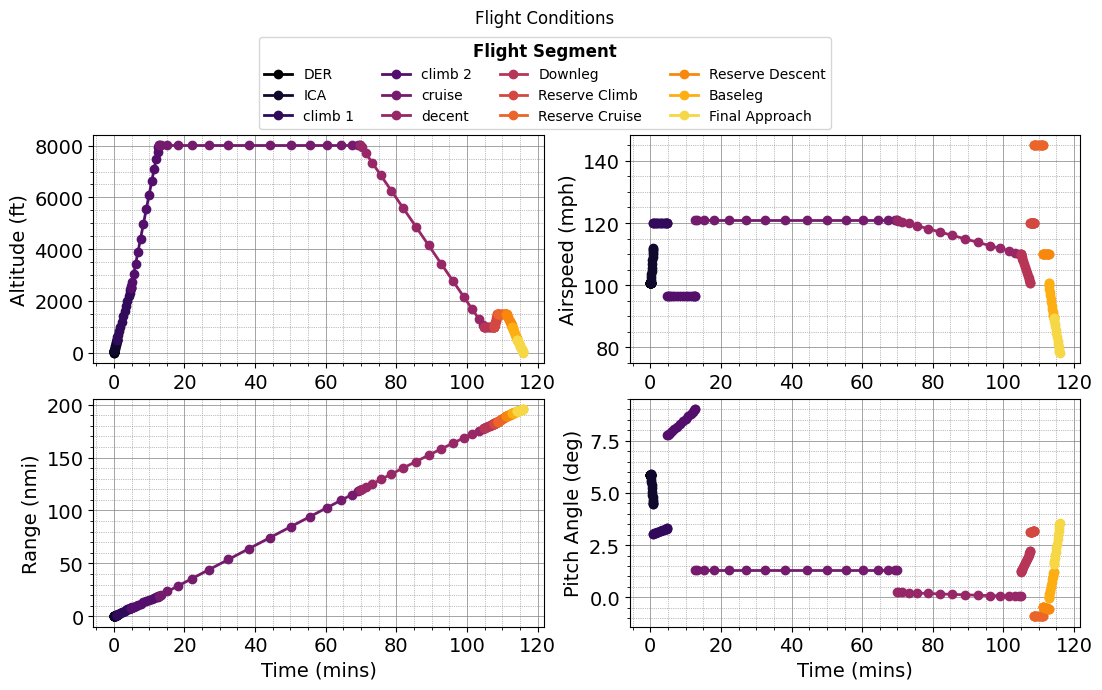

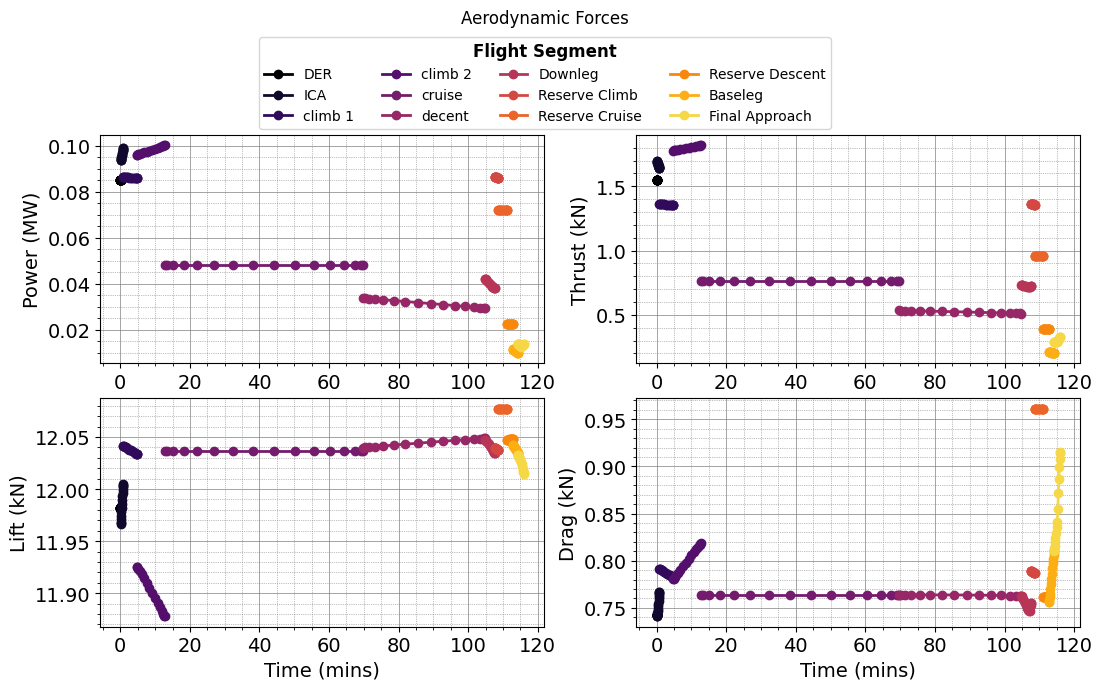

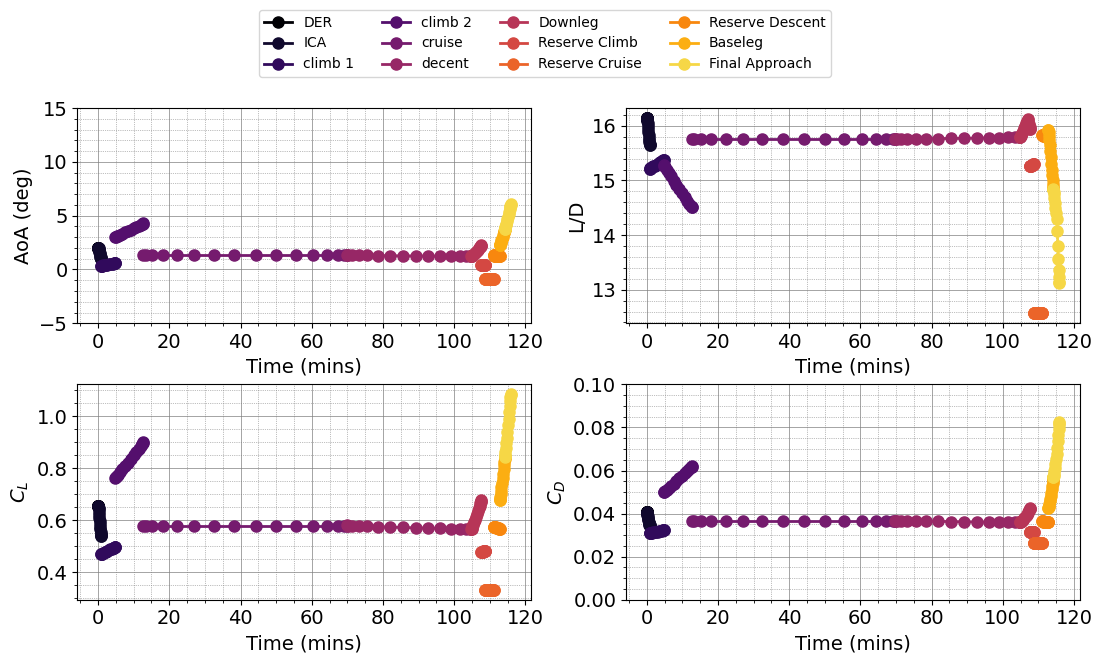

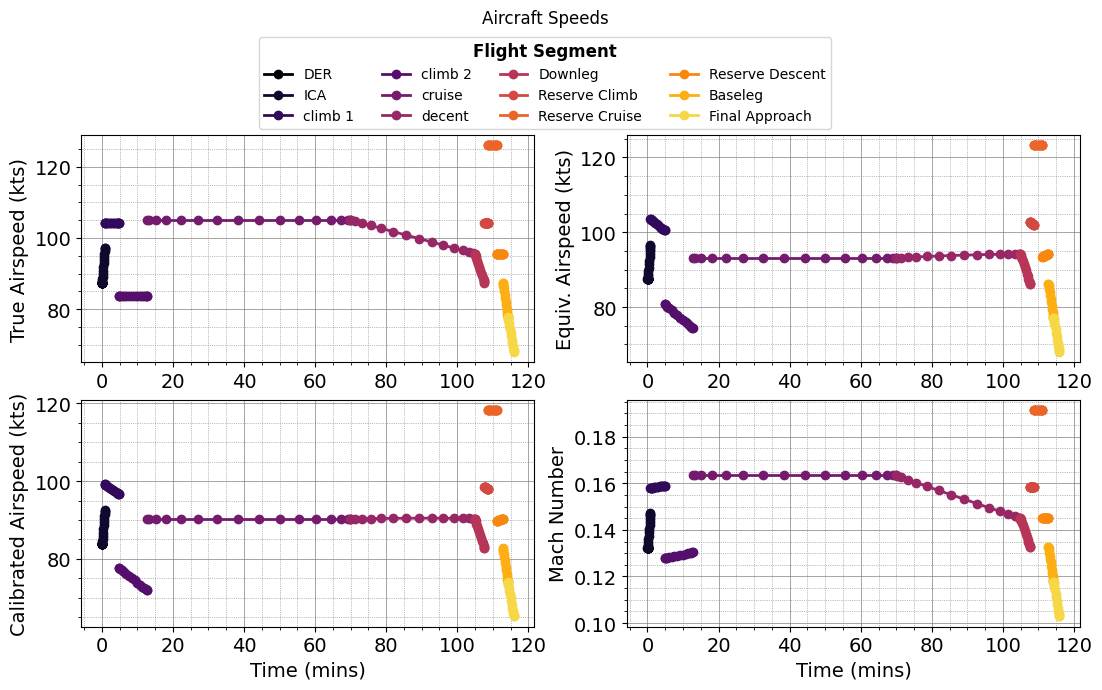

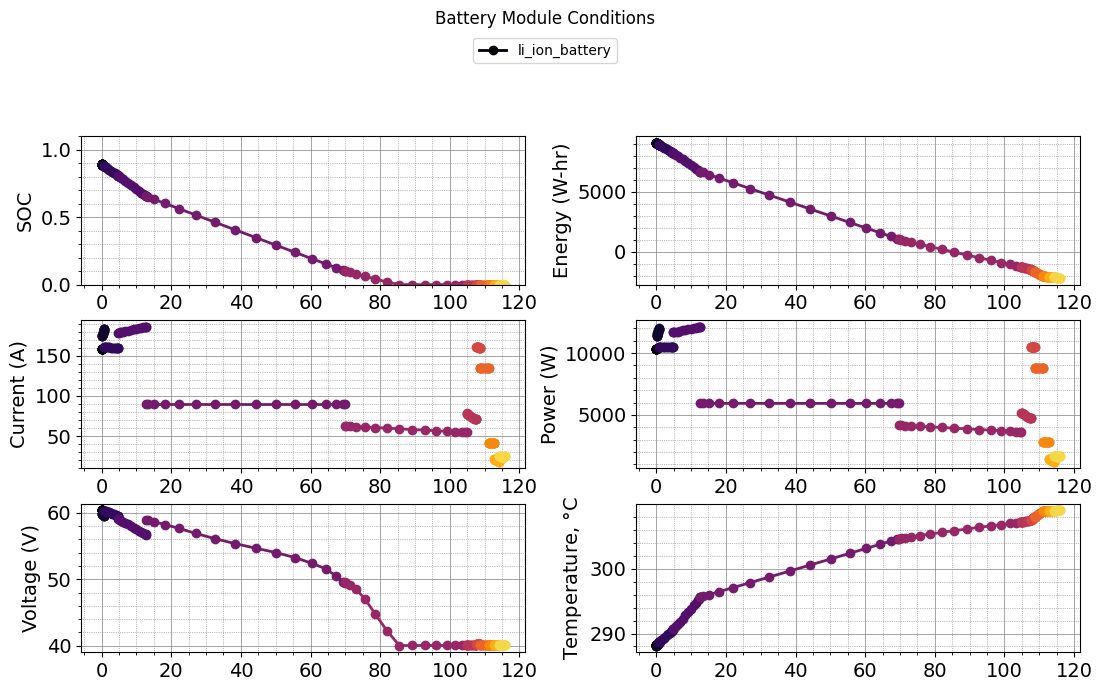

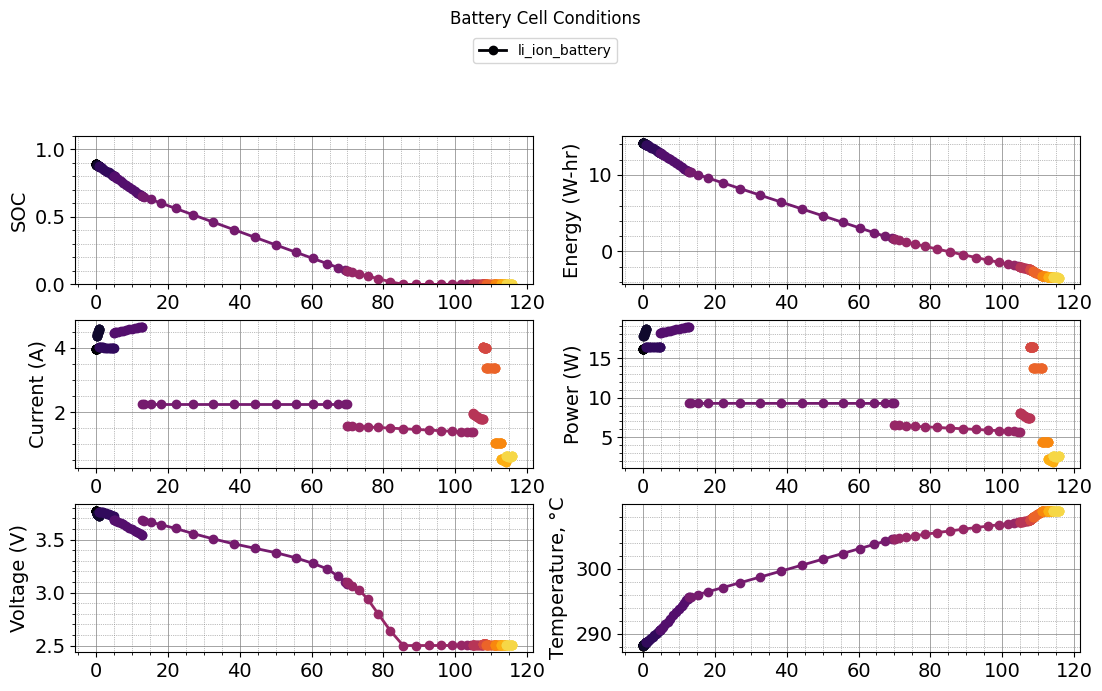

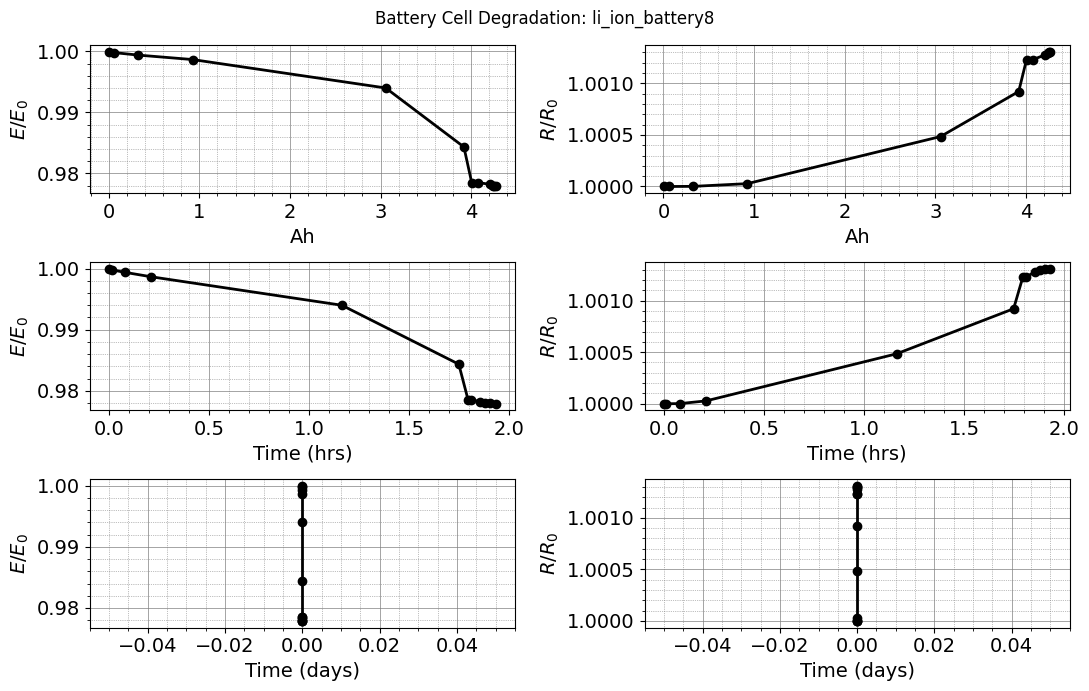

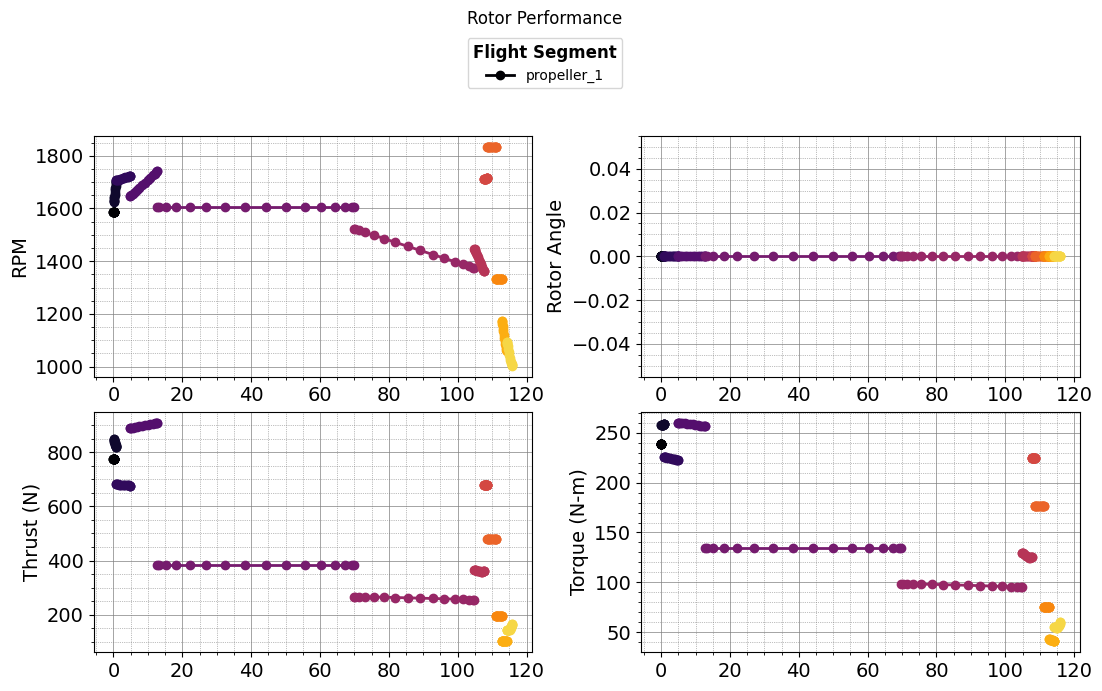

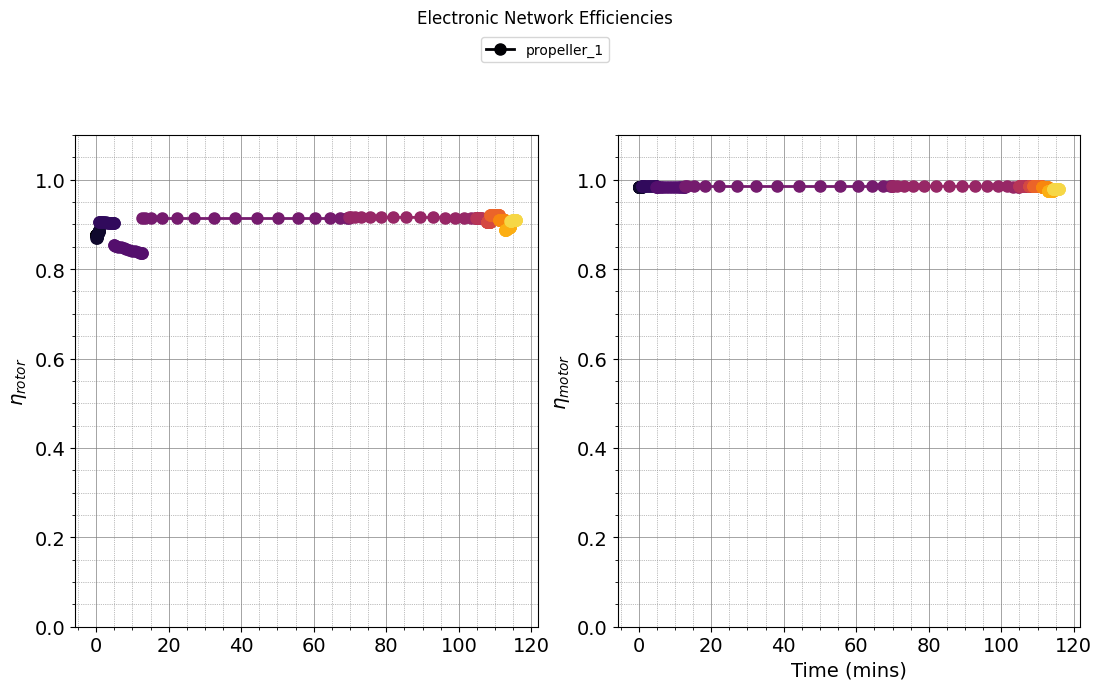

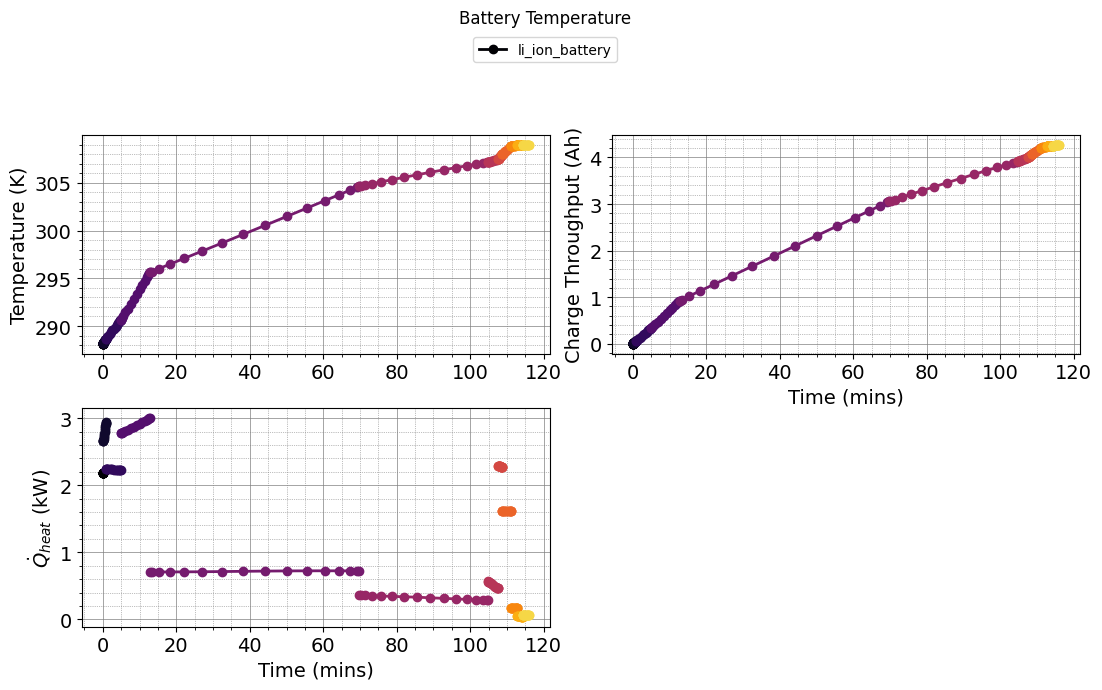

In [36]:
    
# vehicle data
vehicle  = vehicle_setup() 

# Set up vehicle configs
configs  = configs_setup(vehicle)

# create analyses
analyses = analyses_setup(configs)

# mission analyses 
mission = mission_setup(analyses)

# create mission instances (for multiple types of missions)
missions = missions_setup(mission) 

# mission analysis 
results = missions.base_mission.evaluate()  

# plot the results
plot_mission(results) 

# plot vehicle 
#plot_3d_vehicle(configs.base, 
                #min_x_axis_limit            = 0,
                #max_x_axis_limit            = 40,
                #min_y_axis_limit            = -20,
                #max_y_axis_limit            = 20,
                #min_z_axis_limit            = -20,
                #max_z_axis_limit            = 20) 